In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import gensim

import matplotlib.pyplot as plt
import matplotlib

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge

import numpy as np

matplotlib.style.use('ggplot')

## 1. Read data

In [3]:
data_file = "../data/bdata.log.txt"

data = pandas.read_csv(data_file, sep = ',')

In [4]:
data.head()

,species,mhc,peptide_length,cv,sequence,inequality,meas
0,cow,BoLA-HD6,9,TBD,ALFYKDGKL,=,1.000000
1,cow,BoLA-HD6,9,TBD,ALYEKKLAL,=,1.000000
2,cow,BoLA-HD6,9,TBD,AMKDRFQPL,=,0.860543
3,cow,BoLA-HD6,9,TBD,AQRELFFTL,=,1.000000
4,cow,BoLA-HD6,9,TBD,FMKVKFEAL,=,0.957914


In [5]:
print "data shape:", data.shape

data shape: (179692, 7)


In [6]:
print "list of species:", unique(data['species'])

list of species: ['None' 'chimpanzee' 'cow' 'gorilla' 'human' 'macaque' 'mouse']


In [7]:
print "number of unique mhc:", len(unique(data['mhc']))

number of unique mhc: 161


In [8]:
print "number of unique sequences:", len(unique(data['sequence']))

number of unique sequences: 42507


In [9]:
data['meas'].describe()

count    179692.000000
mean          0.271944
std           0.282523
min           0.000000
25%           0.084687
50%           0.112837
75%           0.456245
max           1.000000
Name: meas, dtype: float64

### Some plots

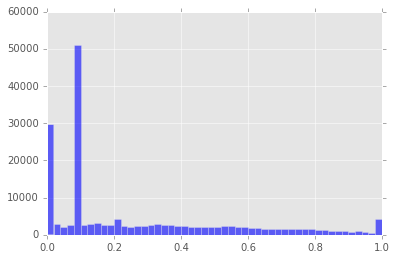

In [ ]:
hh = plt.hist(data['meas'], 50, color = 'blue', alpha = 0.6)

 ## 2. Sequences to vector space

Is it good idea? Who knows... Paragraph2Vec stuff

In [ ]:
s_file = "../data/sequences_spaces.txt"

sentences = gensim.models.doc2vec.TaggedLineDocument(s_file)

model = gensim.models.Doc2Vec(sentences, size = 32, window = 4, workers = 4)

In [ ]:
vecs_df = pandas.DataFrame.from_records(model.docvecs)

In [ ]:
# select one mhc
selected_mhc = 'HLA-A*03:01'

indexes = data['mhc'][data['mhc'] == selected_mhc].index
indexes = data.iloc[indexes]['mhc'][data['peptide_length'] == 9].index
#indexes = data.index
selected_X = vecs_df.iloc[indexes]
selected_y = data['meas'][indexes]

selected_y.describe()

In [ ]:
hh = plt.hist(selected_y, 50, color = 'blue', alpha = 0.6)

## 3. Learn something

In [ ]:
#normalize output
# m = selected_y.mean()
# d = selected_y.max() - selected_y.min()
# selected_y = (selected_y - m) / d

# train/test split
random_number = 42
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y,
                                                    test_size = 0.33, random_state = random_number)

In [ ]:
def ridge_regression(X, y, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(X, y)
    y_pred = ridgereg.predict(X)
    
    #Return the result in pre-defined format
    rss = sum((y_pred - y)**2)
    return rss, ridgereg.intercept_, ridgereg

In [ ]:
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

rss = [0] * 10
intercept = [0] * 10
predictors = [0] * 10

for i in range(10):
    rss[i], intercept[i], predictors[i] = ridge_regression(X_train, y_train, alpha_ridge[i])

In [ ]:
# predict test data

test_rss = [0] * 10
for i in range(10):
    m_pred = predictors[i]
    test_pred = m_pred.predict(X_test)
    test_rss[i] = sum((test_pred - y_test)**2)
    
    print '-' * 10
    print "alpha = ", alpha_ridge[i]
    print "train rss = ", rss[i]
    print "test rss = ", test_rss[i]


m_pred = predictors[5]
test_pred = m_pred.predict(X_test)

In [ ]:
pandas.DataFrame(test_pred).describe()

In [ ]:
test_pred = pandas.DataFrame(test_pred)

and so on...

In [ ]:
y_test = pandas.DataFrame(y_test)

In [ ]:
test_pred['1'] = np.array(y_test)

In [ ]:
test_pred.corr()